In [6]:
from transformers import AutoTokenizer, AutoModel
from qdrant_client import QdrantClient
import gradio as gr
from ollama import generate, pull, Client
import torch

### Examples questions for the user

In [7]:
pre_made_questions = [
    "How can I navigate to a specific pose - include replanning aspects in your answer.",
    "How does ROS2 handle inter-node communication?",
    "Explain the role of DDS in ROS2.",
    "What are lifecycle nodes in ROS2?",
]

### Pull finetuned model

In [84]:
ollama_client = Client(host="http://ollama:11434", timeout=1000)
ollama_client.pull("hf.co/Chinnu1103/ROSLlama-GGUF:Q8_0") #For main RAG-LLM question answer
ollama_client.pull("llama3.2") #For prompt generation

ProgressResponse(status='success', completed=None, total=None, digest=None)

### History object to store user questions

In [26]:
history = None

### Create functions for initializing and implementing the model inference

In [10]:
def generate_embeddings(texts, tokenizer, model, device="cuda:0"):
    tokens = tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        return_tensors="pt", 
        max_length=512
    ).to(device)
    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Use mean pooling
    return embeddings.cpu().numpy()

Generate response from our finetuned model

In [83]:
def query_and_generate_response(user_prompt, vector_db, collection_name, tokenizer, model, top_k=5, device="cpu"):
    user_embedding = generate_embeddings([user_prompt], tokenizer, model, device=device)[0]

    results = vector_db.search(
        collection_name=collection_name,
        query_vector=user_embedding.tolist(),
        limit=top_k
    )
    
    sources = "\n".join([result.payload["metadata"].get("url") for result in results])

    retrieved_content = "\n\n\n".join([result.payload.get("content", "") for result in results])

    prompt = (
        f"This is the document context:\n{retrieved_content}"
        f"\n\n\nThis is the user prompt: {user_prompt}"
        f"\n\nUsing the given document context pertaining to ROS2, answer the question prompted by the user. If you cannot answer it, then say - 'Im sorry I do not have enough context to answer your question'"
    )

    response = ollama_client.generate(model="hf.co/Chinnu1103/ROSLlama-GGUF:Q8_0", prompt=prompt, options = {
        "temperature": 0.1,
        "top_p": 0.9
    })
    
    res_content = response['response']
    res_content += "\n\n"
    res_content += "Sources:\n"
    res_content += sources

    return res_content

In [12]:
def initialize_qdrant(db_path="http://qdrant:6333"):
    client = QdrantClient(db_path, timeout=15)
    return client

In [13]:
def initialize_embedding_model(model_name="sentence-transformers/all-MiniLM-L6-v2"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()  # Set the model to evaluation mode
    return tokenizer, model

Use another LLM to generate a prompt based on user history

In [88]:
def generate_prompt_from_history(user_prompt, history):
    context = f"Main Question:\n{user_prompt}\n\n"
    context += "Previous Question:\n"
    if history:
        context += history
    else:
        context += "NONE"
    
    print(context)
    
    # Refined prompt
    prompt = f"""Rewrite the main user question to include relevant context from the previous question only if it aligns with the user's intent.
    The user is expected to ask ROS2 questions. Do not make any other assumptions that cannot be directly made from the questions.
    If the main prompt diverges significantly from the previous question, return solely the main question without any changes.
    If the main prompt looks like a follow up question, return a reformatted prompt which simply append main question to the previous question.
    Return only the modified prompt without any explanations or other data. Below are the questions:
    
    {context}
    """
    
    # Generate the rewritten prompt using the refined parameters
    res = ollama_client.generate(
        "llama3.2",
        prompt=prompt,
        options={
            "temperature": 0.0,
            "top_p": 1.0,
            "frequency_penalty": 0.2,
            "presence_penalty": 0.0
        }
    )
    
    print("Generated Question:")
    print(res['response'])
    
    return res['response']

In [61]:
def generate_response_from_prompt(prompt, device):
    qdrant_client = initialize_qdrant()
    tokenizer, model = initialize_embedding_model()
    model.to(device)

    # try:
    response = query_and_generate_response(
        user_prompt=prompt,
        vector_db=qdrant_client,
        collection_name="ros2_docs",
        tokenizer=tokenizer,
        model=model,
        device=device
    )
    # except Exception as e:
    #     response = f"An error occurred: {str(e)}"
    
    return response

Create Chat UI

In [ ]:
def chat_interface(user_input, hist):
    global history
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if not user_input:
        return "Please provide a question or select one from the dropdown."
    
    # Generate prompt based on history
    prompt = generate_prompt_from_history(user_input, history)
    
    history = prompt
    
    # Generate response using main model
    response = generate_response_from_prompt(prompt, device)
    
    return {"role": "assistant", "content": response}

In [45]:
def create_ui():
    with gr.Blocks() as app:
        
        # Simplified button click handler
        gr.ChatInterface(
            title="ROS2 Intelligent Assistant (RAG System)",
            description="AI Project Submission for cdb9649",
            chatbot=gr.Chatbot(min_height=600),
            examples=pre_made_questions,
            fn=chat_interface,
            type="messages"
        )
    
    return app

Execute application

In [91]:
app = create_ui()
app.launch(server_name="0.0.0.0", server_port=5000)

/usr/local/lib/python3.10/site-packages/gradio/components/chatbot.py:237: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/gradio/chat_interface.py:214: UserWarning: The type of the chatbot does not match the type of the chat interface. The type of the chat interface will be used.Recieved type of chatbot: {chatbot.type}, type of chat interface: {self.type}
  warnings.warn(


* Running on local URL:  http://0.0.0.0:5000

To create a public link, set `share=True` in `launch()`.


In [89]:
app.close()

Closing server running on port: 5000


## Final LLM Outputs:

Question 1

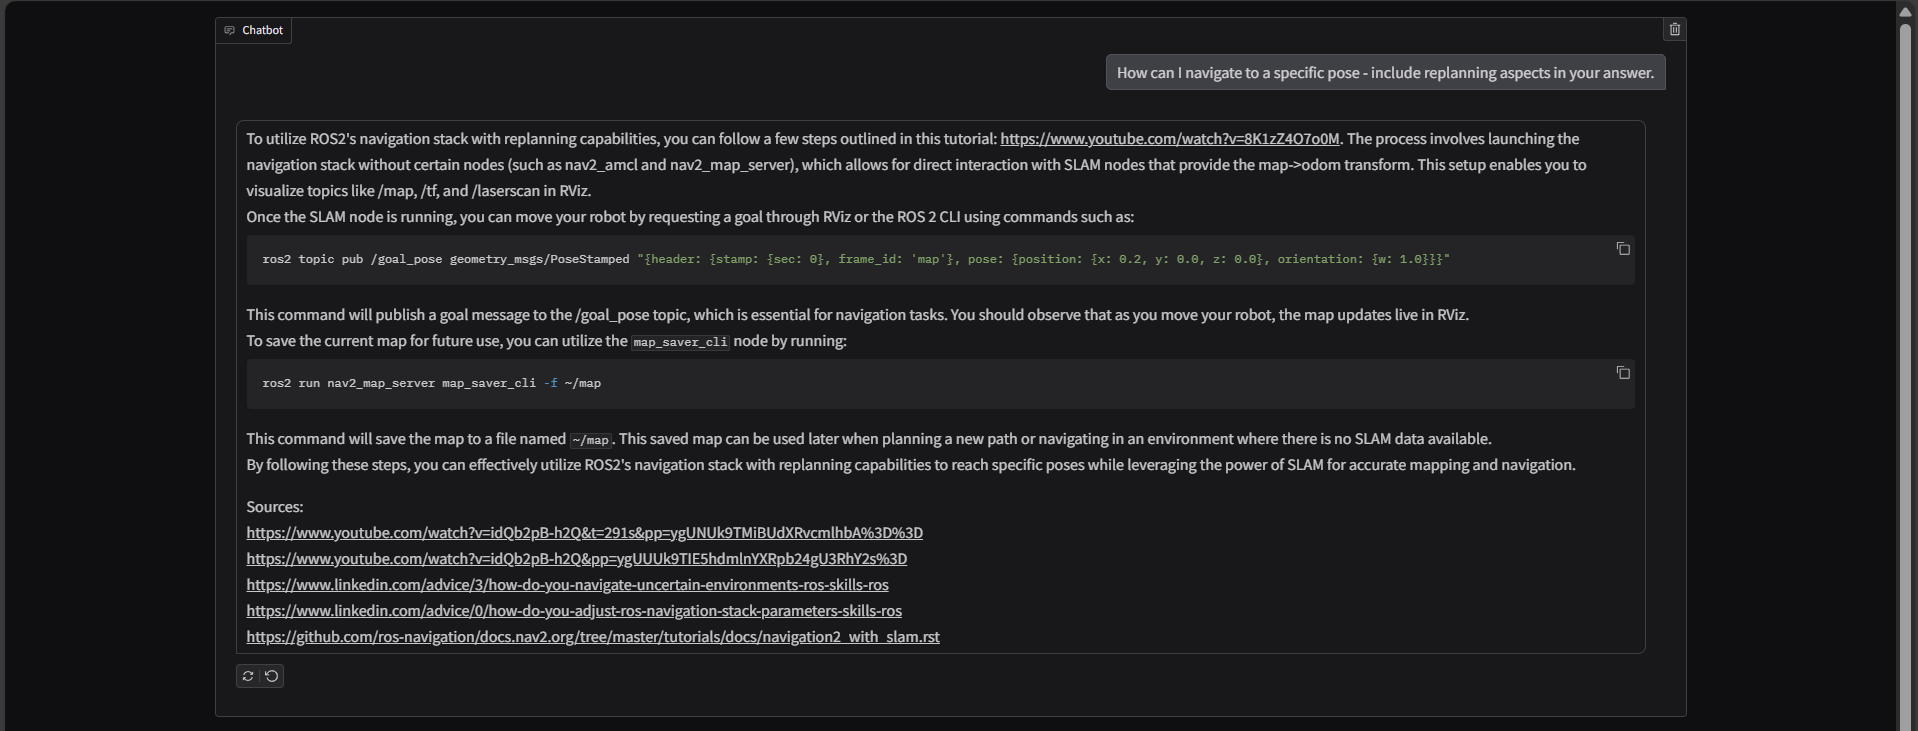

In [96]:
from IPython.display import Image, display
display(Image('screenshots/app_deployment/03_question_1.png'))

Question 2

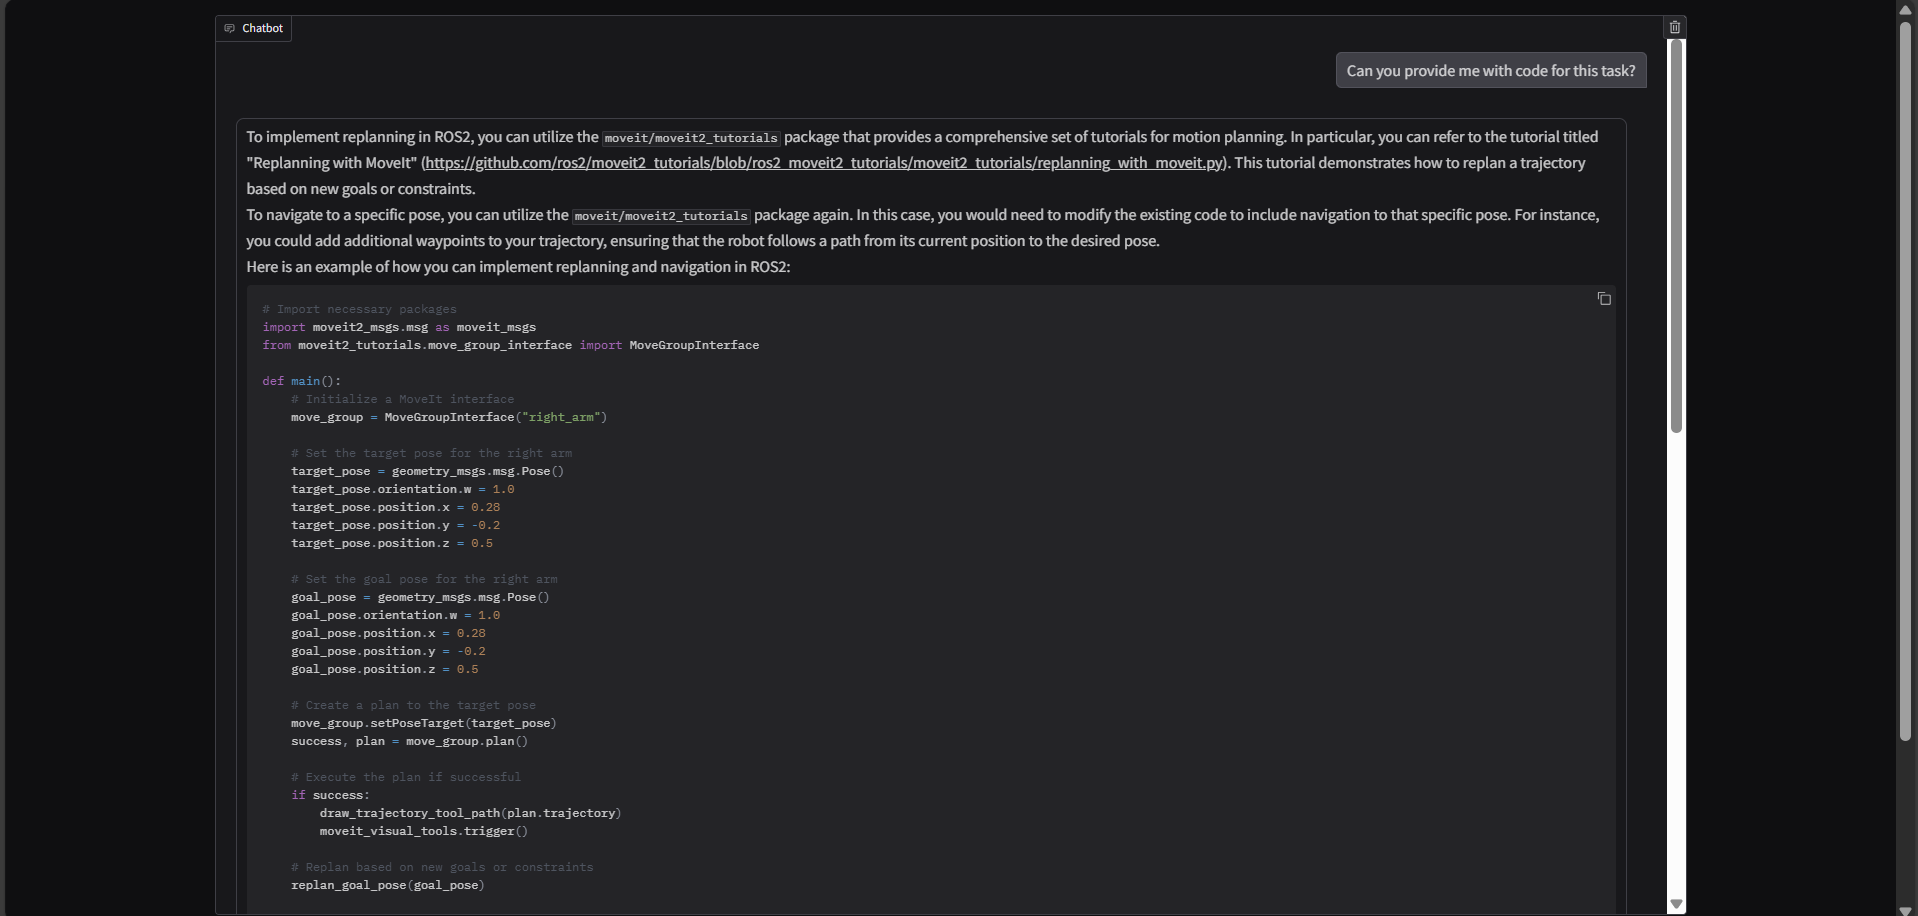

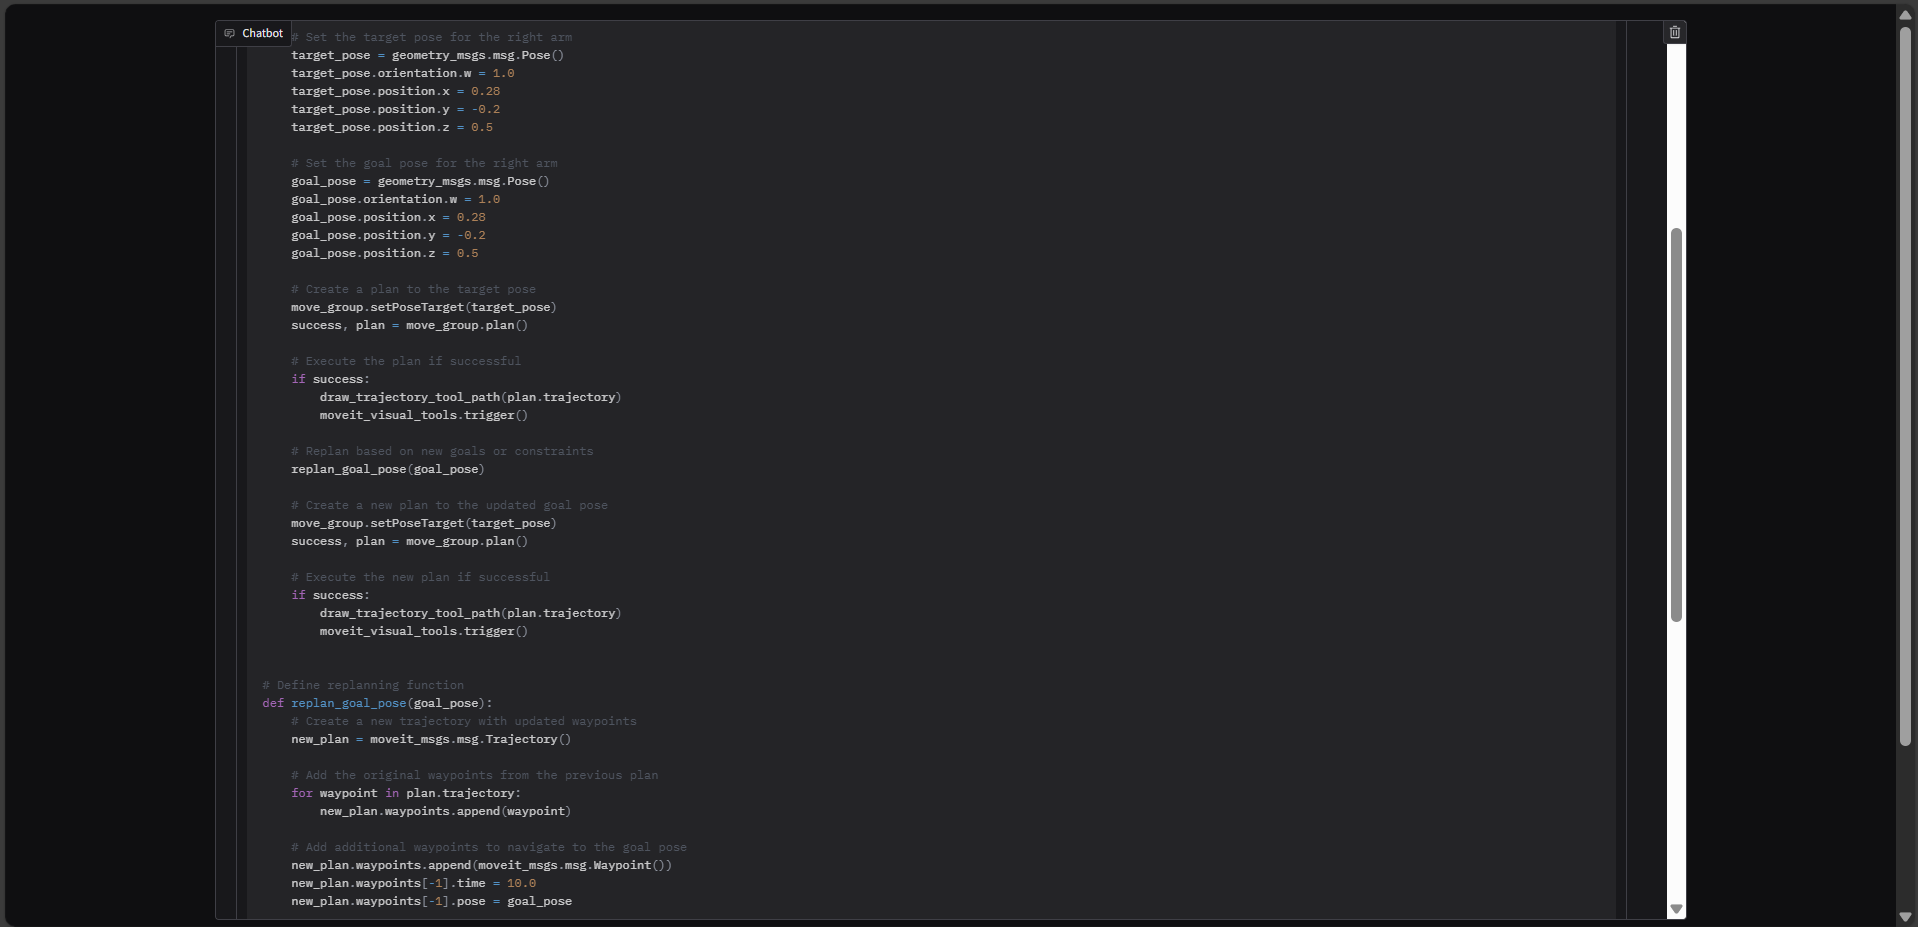

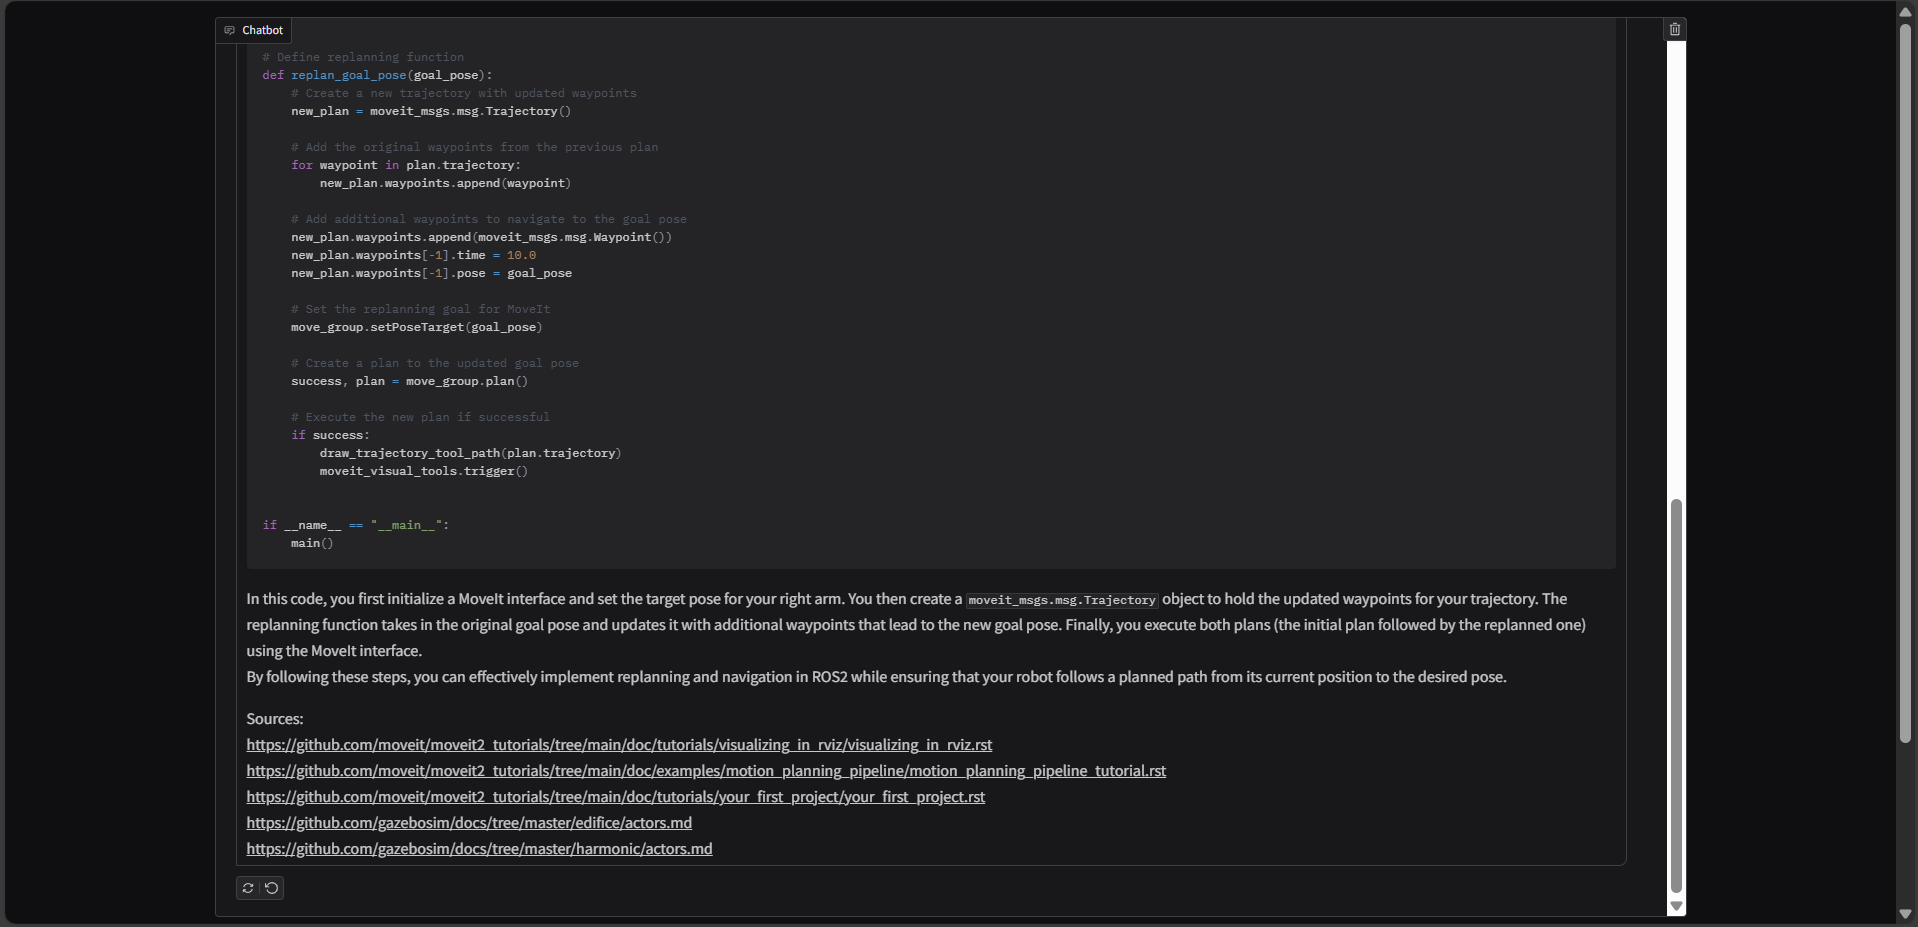

In [98]:
display(Image('screenshots/app_deployment/04_question_2_part_1.png'))
display(Image('screenshots/app_deployment/04_question_2_part_2.png'))
display(Image('screenshots/app_deployment/04_question_2_part_3.png'))

# Coclusion

The application has been deployed using gradio and works as expected.  
From the above outputs we can see that the LLM is able to generate accurate responses and provide all the multimodal sources used for its responses.